# Data Analysis

#### Imports

In [1]:
%matplotlib inline

import pandas as pd
pd.options.display.max_rows = 999
import sqlite3
import statsmodels.formula.api as sm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#### Functions

In [2]:
def normalize(df, feature):
    '''Normalize data'''
    return (df[feature] - df[feature].mean()) / df[feature].std()

def removeOutliers(df, feature):
    '''Remove outliers (more than 3 std devs from mean)'''
    return df[np.abs(df[feature] - df[feature].mean()) <= (3 * df[feature].std())]

def convert_perc_int(df):
    ''''''
    df["occupancy"] = df["occupancy"].apply(lambda x: x * 100)
    df["occupancy"] = df["occupancy"].astype(int)
    return df

#### Database Connection

In [3]:
conn = sqlite3.connect("./sample.db")

#### Occupy Dataframe

In [4]:
df_occupy_1 = pd.read_sql(sql="SELECT room, date, time, associated_client_count, authenticated_client_count FROM occupy", con=conn)
df_occupy_2 = pd.read_sql(sql="SELECT room, date, time, module_code, occupancy FROM occupy", con=conn)

#### Only consider rows with the following conditions satisfied:

* **Condition 1**: time between 9:00 and 16:00
* **Condition 2:** This condition is because we want to take the average authenticated client count between these times. We are disregarding the other figures because we are not sure of the DHCP lease duration. For instance, a number of the devices could still be being considered from an individual who has already left the room but the lease is still considered.
    - time >= quarter past the hour
    - time <= quarter past the hour

In [5]:
df_occupy_1["condition1"] = df_occupy_1["time"].apply(lambda x: "true" if 16 >= int(x[0:2]) >= 9 else "false")
df_occupy_1 = df_occupy_1[df_occupy_1["condition1"] == "true"]

In [6]:
df_occupy_1["condition2"] = df_occupy_1["time"].apply(lambda x: "true" if 45 >= int(x[-2:]) >= 15 else "false")
df_occupy_1 = df_occupy_1[df_occupy_1["condition2"] == "true"]

In [7]:
del df_occupy_1["condition1"]
del df_occupy_1["condition2"]
df_occupy_1["time"] = df_occupy_1["time"].apply(lambda x: x[0:3] + "00")

In [8]:
df_occupy_merge = pd.merge(left = df_occupy_1, right = df_occupy_2, how="outer", on=["room", "date", "time"]) 

In [9]:
df_occupy = df_occupy_merge.groupby(["room", "date", "time", "module_code"], as_index=False).mean()
print(df_occupy.shape)

(172, 7)


#### Remove rows with NaN values 

In [10]:
df_occupy = df_occupy.dropna() 
print(df_occupy.shape)

(153, 7)


#### Module Dataframe

In [11]:
df_module = pd.read_sql(sql="SELECT * FROM module", con=conn)

#### Location Dataframe

In [12]:
df_location = pd.read_sql(sql="SELECT * FROM location", con=conn)

#### Close db connection

In [13]:
conn.close()

## Construct Analytics Base Table

#### Join tables

In [14]:
df_abt = pd.merge(left = df_occupy, right = df_module, how="outer", on=["module_code"]) 
df_abt = pd.merge(left = df_abt, right = df_location, how="outer", on=["room"]) 
print(df_abt.shape)

(154, 11)


#### Remove rows without registered students i.e. no class

In [15]:
df_abt = df_abt[df_abt["reg_students"] != 0]
print(df_abt.shape)

(130, 11)


#### Add occupancy ground truth number to ABT
#### Take min between occupancy gt and reg students to remove error in gt measurement

In [16]:
df_abt["occupancy_number"] = df_abt["occupancy"] * df_abt["capacity"]
df_abt["min_occ_reg"] = df_abt.loc[:, ['occupancy_number', 'reg_students']].min(axis=1)
print(df_abt.shape)

(130, 13)


#### Drop NaN rows

In [17]:
df_abt = df_abt.dropna() 
print(df_abt.shape)

(128, 13)


In [18]:
df_abt

,room,date,time,module_code,associated_client_count,authenticated_client_count,occupancy,reg_students,campus,building,capacity,occupancy_number,min_occ_reg
0,B-002,20151103,10:00,COMP30110,29.000000,29.000000,0.50,45,Belfield,Computer Science,90,45.0,45.0
1,B-002,20151105,10:00,COMP30110,33.166667,33.166667,0.50,45,Belfield,Computer Science,90,45.0,45.0
2,B-002,20151110,10:00,COMP30110,24.666667,24.666667,0.00,45,Belfield,Computer Science,90,0.0,0.0
3,B-002,20151112,10:00,COMP30110,27.166667,27.166667,0.25,45,Belfield,Computer Science,90,22.5,22.5
4,B-002,20151103,11:00,COMP30260,27.200000,27.200000,0.50,18,Belfield,Computer Science,90,45.0,18.0
5,B-002,20151105,12:00,COMP30260,20.833333,20.833333,0.25,18,Belfield,Computer Science,90,22.5,18.0
6,B-002,20151109,14:00,COMP30260,11.333333,11.333333,0.25,18,Belfield,Computer Science,90,22.5,18.0
7,B-002,20151110,11:00,COMP30260,19.333333,19.333333,0.25,18,Belfield,Computer Science,90,22.5,18.0
8,B-002,20151112,12:00,COMP30260,13.833333,13.833333,0.25,18,Belfield,Computer Science,90,22.5,18.0
9,B-002,20151103,12:00,COMP40370,11.833333,11.833333,0.50,27,Belfield,Computer Science,90,45.0,27.0


# Models

### Model 1: Simple Linear (Y: min_occ_reg, X: authenticated_client_count)

In [19]:
df_reg_1= df_abt[["min_occ_reg", "authenticated_client_count"]].copy()
print(df_reg_1.shape)

(128, 2)


#### Feature Analysis

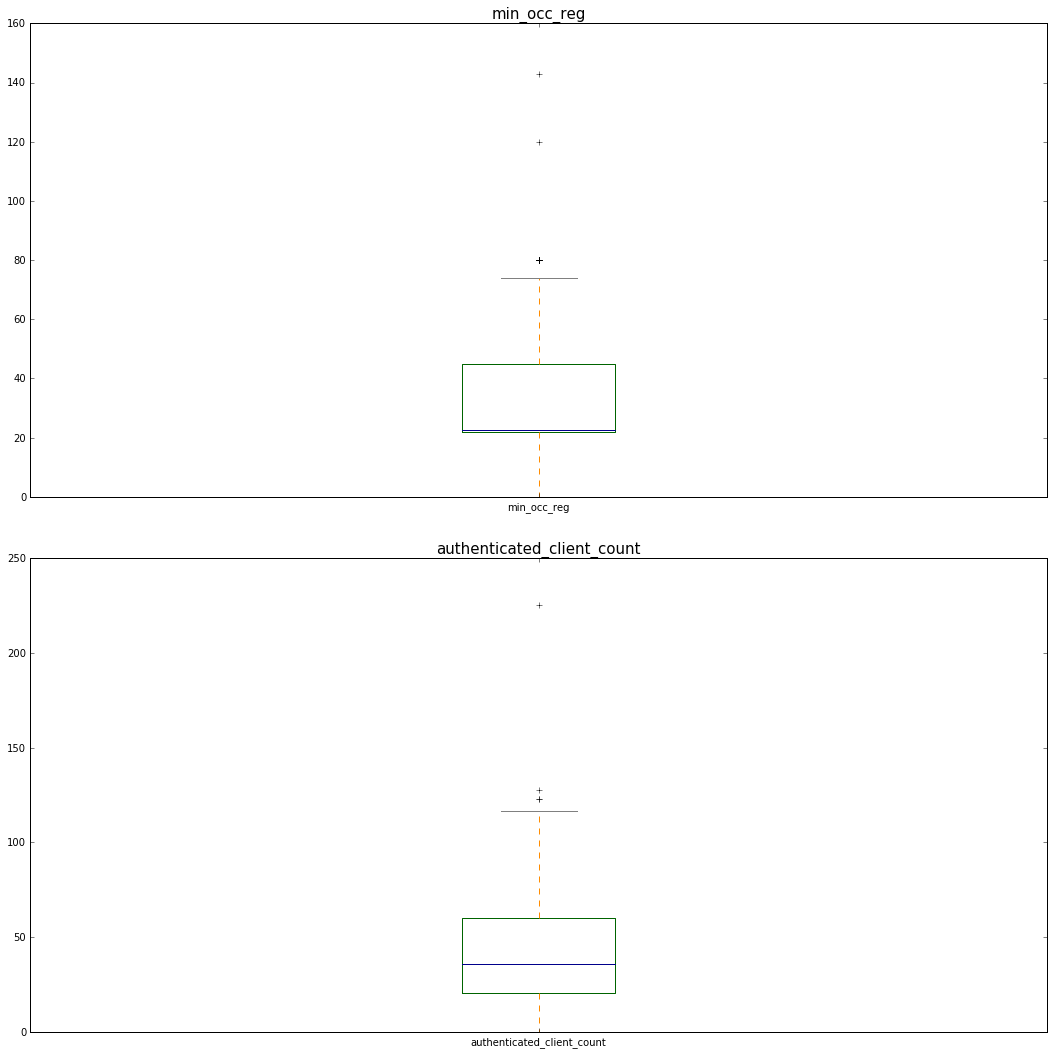

In [20]:
colour = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray') 
plt.figure() 
plt.subplot(211).set_title("min_occ_reg", fontsize=15)
df_reg_1["min_occ_reg"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.subplot(212).set_title("authenticated_client_count", fontsize=15)
df_reg_1["authenticated_client_count"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=3.0) 

#### Normalize Features and remove outliers

In [21]:
df_reg_1["min_occ_reg_NORM"] = normalize(df_reg_1, "min_occ_reg")
df_reg_1["auth_client_count_NORM"] = normalize(df_reg_1, "authenticated_client_count")
print(df_reg_1.shape)
df_reg_1 = removeOutliers(df_reg_1, "min_occ_reg_NORM")
df_reg_1 = removeOutliers(df_reg_1, "auth_client_count_NORM")
df_reg_1 = df_reg_1[["min_occ_reg", "authenticated_client_count"]]
print(df_reg_1.shape)

(128, 4)
(125, 2)


In [22]:
print(df_reg_1.dtypes)
corrMatrix = df_reg_1.corr()
corrMatrix

min_occ_reg                   float64
authenticated_client_count    float64
dtype: object


,min_occ_reg,authenticated_client_count
min_occ_reg,1.000000,0.693793
authenticated_client_count,0.693793,1.000000


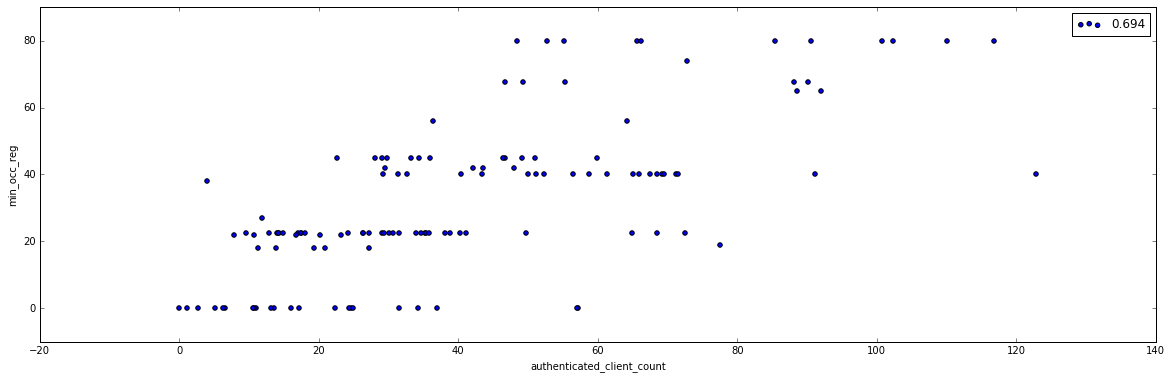

In [23]:
plt.figure() 
df_reg_1.plot(kind="scatter", x="authenticated_client_count", y="min_occ_reg", label="%.3f" % corrMatrix.as_matrix()[0,1], figsize=(20, 6))

#### Statsmodels

In [24]:
lm_sm = sm.ols(formula="min_occ_reg ~ authenticated_client_count - 1", data=df_reg_1).fit()
print(lm_sm.summary())

                            OLS Regression Results                            
Dep. Variable:            min_occ_reg   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     543.5
Date:                Fri, 05 Aug 2016   Prob (F-statistic):           3.74e-47
Time:                        13:56:51   Log-Likelihood:                -533.62
No. Observations:                 125   AIC:                             1069.
Df Residuals:                     124   BIC:                             1072.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
authenticated_client

#### Scikit Learn

Coefficients: 
 [ 0.60086851]
Intercept: 
 7.88177302973
Residual sum of squares: 280.40
Square Root of Residual sum of squares: 16.75
Variance score: 0.48


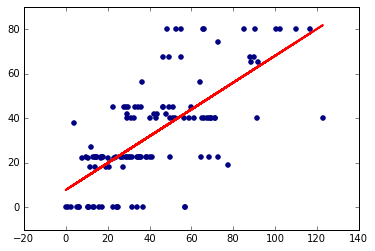

In [25]:
X = df_reg_1["authenticated_client_count"].reshape(len(df_reg_1["authenticated_client_count"]), 1)
y = df_reg_1["min_occ_reg"]

lm_scikit_1 = LinearRegression()

# Fit the model 
lm_scikit_1.fit(X, y)

# Coefficients
print("Coefficients: \n", lm_scikit_1.coef_)
# The intercept
print('Intercept: \n', lm_scikit_1.intercept_)
# The mean square error: MSE is more popular than MAE because MSE "punishes" larger errors. 
# But, RMSE is even more popular than MSE because RMSE is interpretable in the "y" units.
print("Residual sum of squares: %.2f" % metrics.mean_squared_error(y, lm_scikit_1.predict(X)))
print("Square Root of Residual sum of squares: %.2f" % np.sqrt(metrics.mean_squared_error(y, lm_scikit_1.predict(X))))
# Explained variance score: coefficient of determination (R^2)
print("Variance score: %.2f" % lm_scikit_1.score(X, y))

# Plot outputs
plt.scatter(X, y,  color='navy')
plt.plot(X, lm_scikit_1.predict(X), color='red',linewidth=2)
plt.figure(figsize=(20,20))
plt.show()

#### Train & Testing

**Cross Validation**

In [26]:
R2_scores_1 = cross_val_score(lm_scikit_1.fit(X, y), X.astype(int), y.astype(int), cv=5, scoring="r2")
print(R2_scores_1)

[ 0.24550165 -0.08107307  0.28460772  0.4503266   0.32127097]


**Train and test** 

Coefficients:  [ 0.67792252]
Intercept:  5.64985924496
Residual sum of squares: 368.66
Square Root of Residual sum of squares: 19.20
Variance score: 0.31


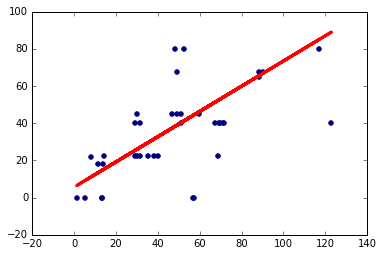

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lm_scikit_1_t = LinearRegression()

# Train the model using the training sets
lm_scikit_1_t.fit(X_train, y_train)

# The coefficients
print('Coefficients: ', lm_scikit_1_t.coef_)
# The intercept
print('Intercept: ', lm_scikit_1_t.intercept_)
# The mean square error
print("Residual sum of squares: %.2f" % metrics.mean_squared_error(y_test, lm_scikit_1_t.predict(X_test)))
print("Square Root of Residual sum of squares: %.2f" % np.sqrt(metrics.mean_squared_error(y_test, lm_scikit_1_t.predict(X_test))))
# Explained variance score: coefficient of determination (R^2)
print('Variance score: %.2f' % lm_scikit_1_t.score(X_test, y_test))

# Plot outputs
plt.scatter(X_test, y_test,  color='navy')
plt.plot(X_test, lm_scikit_1_t.predict(X_test), color='red',linewidth=3)
plt.figure(figsize=(20,20))
plt.show()

### Model 2: Simple Linear (Y: min_occ_reg, X: asso_client_count)

In [28]:
df_reg_2= df_abt[["min_occ_reg", "associated_client_count"]].copy()
print(df_reg_2.shape)

(128, 2)


#### Feature Analysis

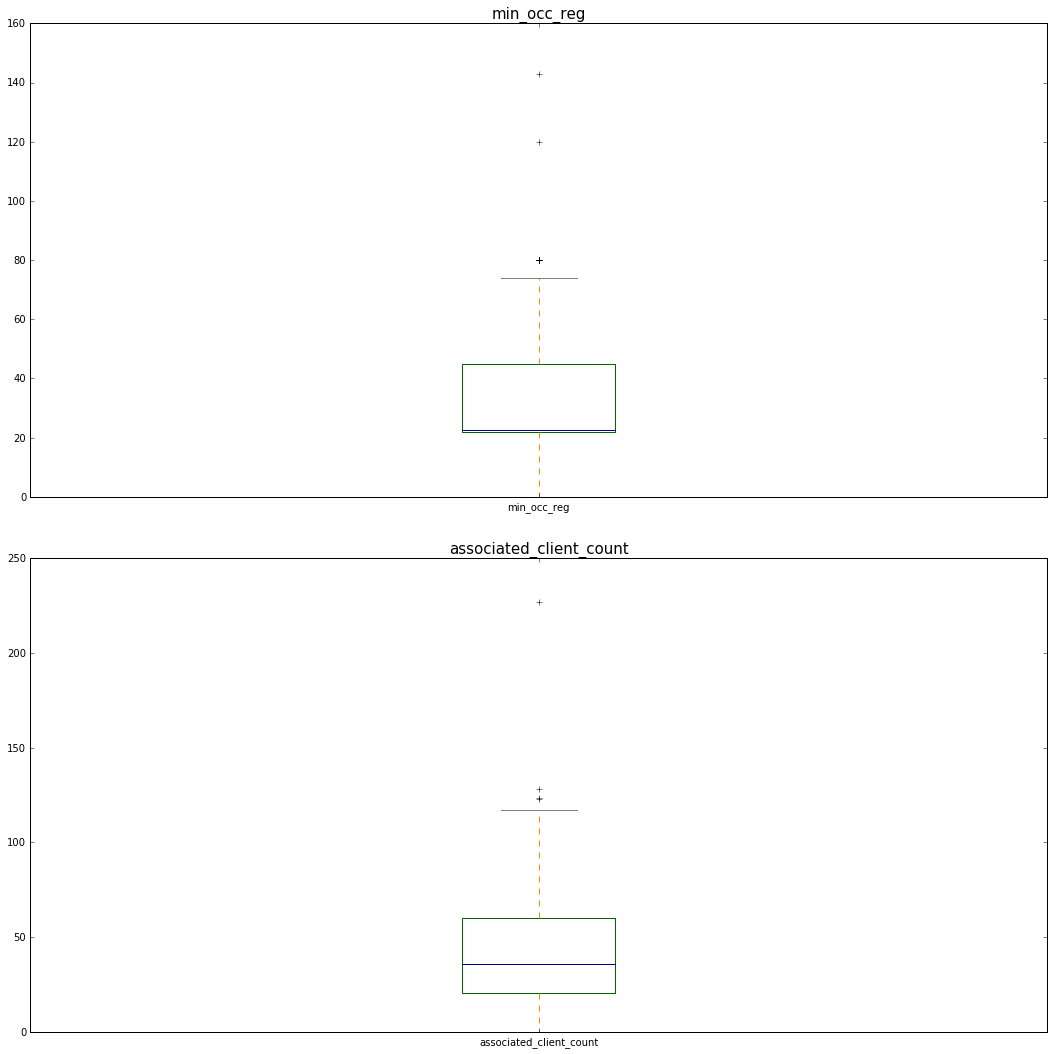

In [29]:
plt.figure() 
plt.subplot(211).set_title("min_occ_reg", fontsize=15)
df_reg_2["min_occ_reg"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.subplot(212).set_title("associated_client_count", fontsize=15)
df_reg_2["associated_client_count"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=3.0) #set padding

#### Normalize Features and remove outliers

In [30]:
df_reg_2["min_occ_reg_NORM"] = normalize(df_reg_2, "min_occ_reg")
df_reg_2["asso_client_count_NORM"] = normalize(df_reg_2, "associated_client_count")
print(df_reg_2.shape)
df_reg_2 = removeOutliers(df_reg_2, "min_occ_reg_NORM")
df_reg_2 = removeOutliers(df_reg_2, "asso_client_count_NORM")
df_reg_2 = df_reg_2[["min_occ_reg", "associated_client_count"]]
print(df_reg_2.shape)

(128, 4)
(125, 2)


In [31]:
print(df_reg_2.dtypes)
corrMatrix = df_reg_2.corr()
corrMatrix

min_occ_reg                float64
associated_client_count    float64
dtype: object


,min_occ_reg,associated_client_count
min_occ_reg,1.000000,0.693639
associated_client_count,0.693639,1.000000


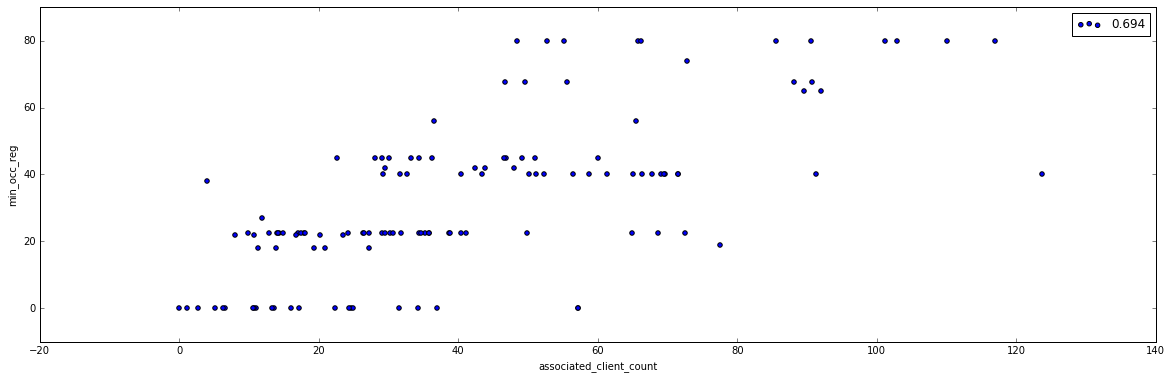

In [32]:
plt.figure() 
df_reg_2.plot(kind="scatter", x="associated_client_count", y="min_occ_reg", label="%.3f" % corrMatrix.as_matrix()[0,1], figsize=(20, 6))

In [33]:
lm_sm_2 = sm.ols(formula="min_occ_reg ~ associated_client_count - 1", data=df_reg_2).fit()
print(lm_sm_2.summary())

                            OLS Regression Results                            
Dep. Variable:            min_occ_reg   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     543.1
Date:                Fri, 05 Aug 2016   Prob (F-statistic):           3.91e-47
Time:                        13:56:52   Log-Likelihood:                -533.66
No. Observations:                 125   AIC:                             1069.
Df Residuals:                     124   BIC:                             1072.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
associated_client_count   

Coefficients: 
 [ 0.59885264]
Intercept: 
 7.89820771409
Residual sum of squares: 280.51
Square Root of Residual sum of squares: 16.75
Variance score: 0.48


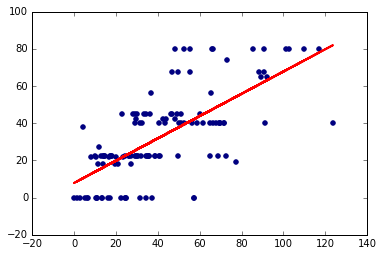

In [34]:
X = df_reg_2["associated_client_count"].reshape(len(df_reg_2["associated_client_count"]), 1)
y = df_reg_2["min_occ_reg"]

lm_scikit_2 = LinearRegression()

# Fit the model 
lm_scikit_2.fit(X, y)

# Coefficients
print("Coefficients: \n", lm_scikit_2.coef_)
# The intercept
print('Intercept: \n', lm_scikit_2.intercept_)
# The mean square error: MSE is more popular than MAE because MSE "punishes" larger errors. 
# But, RMSE is even more popular than MSE because RMSE is interpretable in the "y" units.
print("Residual sum of squares: %.2f" % metrics.mean_squared_error(y, lm_scikit_2.predict(X)))
print("Square Root of Residual sum of squares: %.2f" % np.sqrt(metrics.mean_squared_error(y, lm_scikit_2.predict(X))))
# Explained variance score: coefficient of determination (R^2)
print("Variance score: %.2f" % lm_scikit_2.score(X, y))

# Plot outputs
plt.scatter(X, y,  color='navy')
plt.plot(X, lm_scikit_2.predict(X), color='red',linewidth=2)
plt.figure(figsize=(20,20))
plt.show()

#### Train & Testing

**Cross Validation**

In [35]:
R2_scores_2 = cross_val_score(lm_scikit_2.fit(X, y), X.astype(int), y.astype(int), cv=5)
print(R2_scores_2)

[ 0.24260432 -0.07764585  0.28032236  0.45079952  0.32430428]


**Train and test** 

Coefficients: 
 [ 0.61334317]
Intercept: 
 5.88360917451
Residual sum of squares: 308.64
Square Root of Residual sum of squares: 17.57
Variance score: 0.42


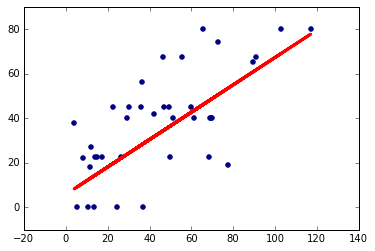

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lm_scikit_2_t = LinearRegression()

# Train the model using the training sets
lm_scikit_2_t.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', lm_scikit_2_t.coef_)
# The intercept
print('Intercept: \n', lm_scikit_2_t.intercept_)
# The mean square error
print("Residual sum of squares: %.2f" % metrics.mean_squared_error(y_test, lm_scikit_2_t.predict(X_test)))
print("Square Root of Residual sum of squares: %.2f" % np.sqrt(metrics.mean_squared_error(y_test, lm_scikit_2_t.predict(X_test))))
# Explained variance score: coefficient of determination (R^2)
print('Variance score: %.2f' % lm_scikit_2_t.score(X_test, y_test))

# Plot outputs
plt.scatter(X_test, y_test,  color='navy')
plt.plot(X_test, lm_scikit_2_t.predict(X_test), color='red',linewidth=3)
plt.figure(figsize=(20,20))
plt.show()

### Categoriztion Models

In [37]:
df = df_abt[["occupancy", "authenticated_client_count"]].copy()
df = convert_perc_int(df)

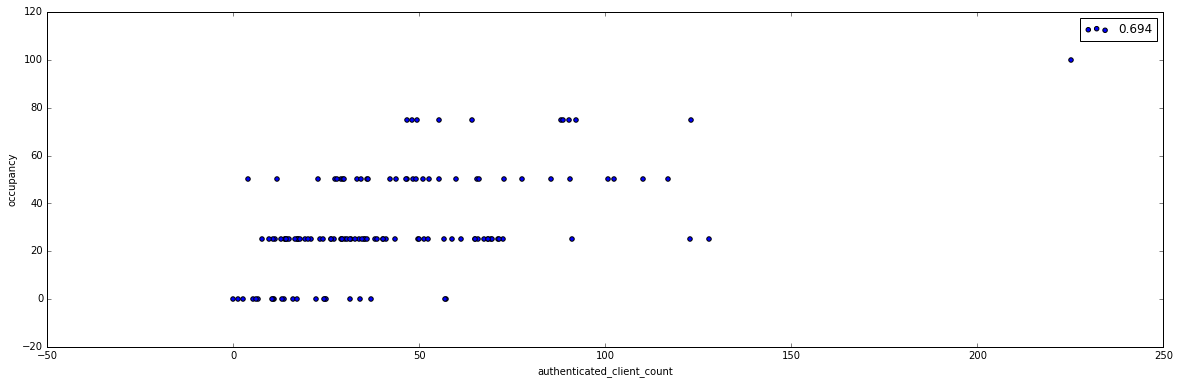

In [38]:
plt.figure() 
df.plot(kind="scatter", x="authenticated_client_count", y="occupancy", label="%.3f" % corrMatrix.as_matrix()[0,1], figsize=(20, 6))

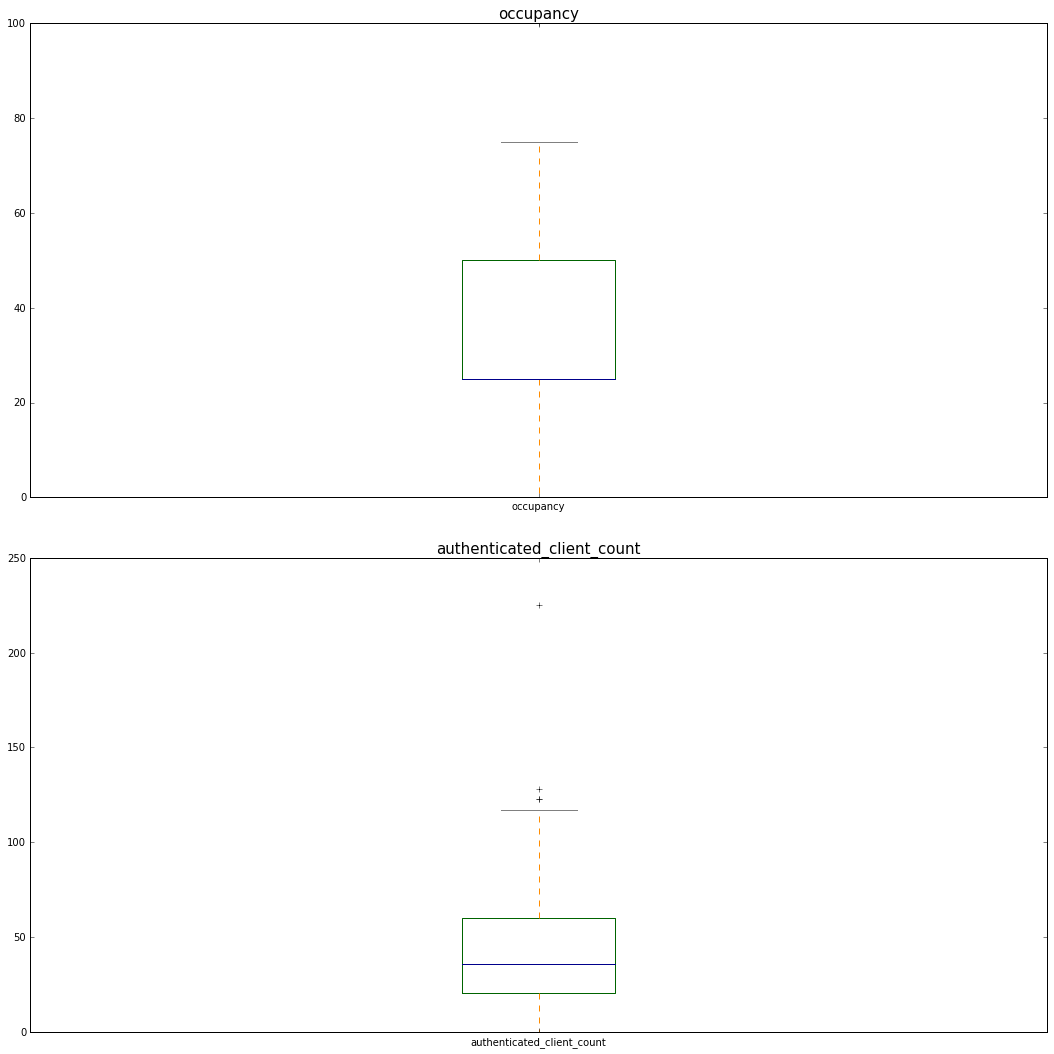

In [39]:
plt.figure() 
plt.subplot(211).set_title("occupancy", fontsize=15)
df["occupancy"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.subplot(212).set_title("authenticated_client_count", fontsize=15)
df["authenticated_client_count"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=3.0) 

In [40]:
# df["occupancy_NORM"] = normalize(df, "occupancy")
# df["authenticated_client_count_NORM"] = normalize(df, "authenticated_client_count")
# print(df.shape)
# df = removeOutliers(df, "occupancy_NORM")
# df = removeOutliers(df, "authenticated_client_count_NORM")
# df = df[["occupancy", "authenticated_client_count"]]
# print(df.shape)

### Multinomial Logistic Regression http://machinelearningmastery.com/get-your-hands-dirty-with-scikit-learn-now/

log-odds of a categorical response being "true" (1) is modeled as a linear combination of the features.
Logistic regression outputs the probabilities of a specific class
Those probabilities can be converted into class predictions

In [41]:
df_log_1 = df.copy()
X = df_log_1["authenticated_client_count"].reshape(len(df_log_1["authenticated_client_count"]), 1)
y = df_log_1["occupancy"]
lr = LogisticRegression()
lr.fit(X, y)
pred_lr = lr.predict(X)
print(metrics.classification_report(y, pred_lr))
print(metrics.confusion_matrix(y, pred_lr))
print(metrics.accuracy_score(y, pred_lr) )

             precision    recall  f1-score   support

          0       1.00      0.09      0.17        22
         25       0.50      0.97      0.66        63
         50       0.20      0.03      0.05        32
         75       0.00      0.00      0.00        10
        100       0.00      0.00      0.00         1

avg / total       0.47      0.50      0.37       128

[[ 2 20  0  0  0]
 [ 0 61  2  0  0]
 [ 0 31  1  0  0]
 [ 0  9  1  0  0]
 [ 0  0  1  0  0]]
0.5


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [42]:
df_log_1["predicted"] = pd.Series(pred_lr, index=df_log_1.index)

In [51]:
####### How to use model to return occupancy prediction #######
# lr.predict_proba(X)
groups = [0, 25, 50, 75, 100]
lr.predict_proba(X).argmax(axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

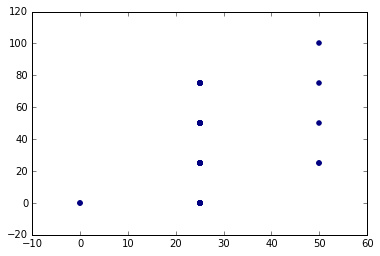

In [52]:
plt.scatter(df_log_1["predicted"], df_log_1["occupancy"],  color='navy')
plt.figure(figsize=(20,20))
plt.show()

In [ ]:
plt.scatter(df_log_1["authenticated_client_count"], df_log_1["occupancy"],  color='navy')
plt.scatter(df_log_1["authenticated_client_count"], df_log_1["predicted"],  color='green')
plt.figure(figsize=(20,20))
plt.show()

### Gaussian Naive Bayes 

In [ ]:
df_gnb = df.copy()
X = df_gnb["authenticated_client_count"].reshape(len(df_gnb["authenticated_client_count"]), 1)
y = df_gnb["occupancy"]
# fit a Naive Bayes model to the data
gnb = GaussianNB()
gnb.fit(X, y)
pred_gnb = gnb.predict(X)
print(metrics.classification_report(y, pred_gnb))
print(metrics.confusion_matrix(y, pred_gnb))

In [ ]:
df_gnb["predicted"] = pd.Series(pred_gnb, index=df_gnb.index)

In [ ]:
####### How to use model to return occupancy prediction #######
# groups = np.sort(y.unique())
# groups[int(gnb.predict_proba(x).argmax(axis=1))]

In [ ]:
plt.scatter(df_gnb["predicted"], df_gnb["occupancy"],  color='navy')
plt.figure(figsize=(20,20))
plt.show()

In [ ]:
plt.scatter(df_gnb["authenticated_client_count"], df_gnb["occupancy"],  color='navy')
plt.scatter(df_gnb["authenticated_client_count"], df_gnb["predicted"],  color='green')
plt.figure(figsize=(20,20))
plt.show()

### k-Nearest Neighbor

In [ ]:
df_nn = df.copy()
X = df_nn["authenticated_client_count"].reshape(len(df_nn["authenticated_client_count"]), 1)
y = df_nn["occupancy"] 
nn = KNeighborsClassifier()
nn.fit(X, y)
pred_nn = nn.predict(X)
print(metrics.classification_report(y, pred_nn))
print(metrics.confusion_matrix(y, pred_nn))

In [ ]:
df_nn["predicted"] = pd.Series(pred_nn, index=df_nn.index)

In [ ]:
####### How to use model to return occupancy prediction #######
# groups = np.sort(y.unique())
# groups[int(nn.predict_proba(x).argmax(axis=1))]

In [ ]:
plt.scatter(df_nn["predicted"], df_nn["occupancy"],  color='navy')
plt.figure(figsize=(20,20))
plt.show()

In [ ]:
plt.scatter(df_nn["authenticated_client_count"], df_nn["occupancy"],  color='navy')
plt.scatter(df_nn["authenticated_client_count"], df_nn["predicted"],  color='green')
plt.figure(figsize=(20,20))
plt.show()

### Support Vector Machines

In [ ]:
df_svm = df.copy()
X = df_svm["authenticated_client_count"].reshape(len(df_svm["authenticated_client_count"]), 1)
y = df_svm["occupancy"] 
svc = SVC()
svc.fit(X, y)
pred_svm = svc.predict(X)
print(metrics.classification_report(y, pred_svm))
print(metrics.confusion_matrix(y, pred_svm))

In [ ]:
df_svm["predicted"] = pd.Series(pred_svm, index=df_svm.index)

In [ ]:
####### How to use model to return occupancy prediction #######
# groups = np.sort(y.unique())
# groups[int(svc.predict_proba(x).argmax(axis=1))]

In [ ]:
plt.scatter(df_svm["predicted"], df_svm["occupancy"],  color='navy')
plt.figure(figsize=(20,20))
plt.show()

In [ ]:
plt.scatter(df_svm["authenticated_client_count"], df_svm["occupancy"],  color='navy')
plt.scatter(df_svm["authenticated_client_count"], df_svm["predicted"],  color='green')
plt.figure(figsize=(20,20))
plt.show()